In [2]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, time
import pandas as pd
#for filter
from scipy.signal import butter
from scipy.signal import lfilter
from scipy.signal import freqz;
from scipy.signal import find_peaks
import scipy
from scipy import signal
import librosa
import librosa.display
import os
import math
import latexify as lt

#%matplotlib notebook

In [4]:
def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2

    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return (fft_freqs, fft_amplitudes);

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='lowpass', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y;

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='highpass', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y;

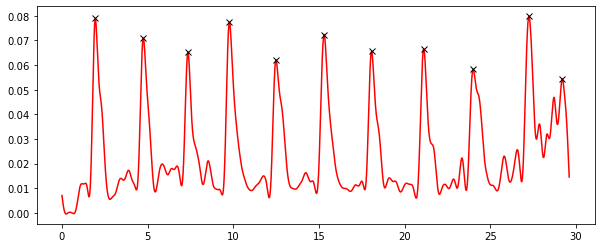

In [8]:
#now using hilbert transform
#https://www.atsjournals.org/doi/10.1164/ajrccm.162.3.9905104


filename="audacity-1.wav"
tidal, fs = librosa.load(filename, sr=4000)
tidal_t = [s/fs for s in range(0,len(tidal))]
#filtering using band passfilter
cutoff_low = 5
cutoff_low_lpf = 150
cutoff_high = 100
order = 5
#tidal_f = butter_bandpass_filter(tidal,cutoff_low,cutoff_high,fs,order)
tidal_f = butter_lowpass_filter(tidal,cutoff_low_lpf,fs,order)


x_filt_hilbert = signal.hilbert(tidal_f)
envelope_hat = np.abs(x_filt_hilbert)
#filter the Hilbert envelope
nyq_rate = fs /0.5
width = 1.0/nyq_rate # 5 Hz filter transition width.
ripple_db = 10.0 # stop band attenuation
fL_hz = 10
N, beta = signal.kaiserord(ripple_db, width)
taps = signal.firwin(N, fL_hz/nyq_rate, window=('kaiser', beta))
envelope_hat_filt = signal.filtfilt(taps, 1,envelope_hat)
peaks,_ = find_peaks(envelope_hat_filt, height=0.05)


fig, ax = plt.subplots(1,1,figsize=(10,4))
#ax[0].plot(tidal_t, tidal,'k', alpha=0.5);
#ax.plot(tidal_t,tidal_f, 'b', alpha=0.6)

ax.plot(tidal_t,envelope_hat_filt,'r');
ax.plot([tidal_t[peak] for peak in peaks], [envelope_hat_filt[i] for i in peaks], "x", color='black')
#ax[2].set_title("File name = {} and No. of breathing = {}".format(filename, (len(peaks)-2)//2))






In [70]:
rr_list = [tidal_t[peak] for peak in peaks]
print("Average Peak to Peak Time = {}".format(np.mean(np.diff(np.array(rr_list)))))
total_peaks = len(np.diff(np.array(rr_list)))+1
print("RR = {}".format(np.mean(np.diff(np.array(rr_list)))*(total_peaks)))

Average Peak to Peak Time = 2.7254750000000003
RR = 29.980225000000004


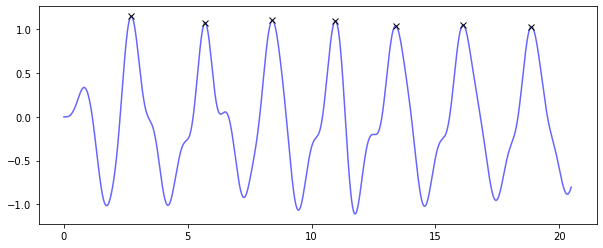

In [40]:
#now using hilbert transform
#https://www.atsjournals.org/doi/10.1164/ajrccm.162.3.9905104


filename="arduino-1.wav"
tidal, fs = librosa.load(filename, sr=4000)
tidal_t = [s/fs for s in range(0,len(tidal))]
#filtering using band passfilter
cutoff_low = 5
cutoff_low_lpf = 1
cutoff_high = 100
order = 5
#tidal_f = butter_bandpass_filter(tidal,cutoff_low,cutoff_high,fs,order)
tidal_f = butter_lowpass_filter(tidal,cutoff_low_lpf,fs,order)


x_filt_hilbert = signal.hilbert(tidal_f)
envelope_hat = np.abs(x_filt_hilbert)
#filter the Hilbert envelope
nyq_rate = fs /0.5
width = 1.0/nyq_rate # 5 Hz filter transition width.
ripple_db = 10.0 # stop band attenuation
fL_hz = 10
N, beta = signal.kaiserord(ripple_db, width)
taps = signal.firwin(N, fL_hz/nyq_rate, window=('kaiser', beta))
envelope_hat_filt = signal.filtfilt(taps, 1,envelope_hat)
peaks_ht,_ = find_peaks(envelope_hat_filt, height=0.05)
peaks_f,_ = find_peaks(tidal_f, height=0.5)


fig, ax = plt.subplots(1,1,figsize=(10,4))
#ax.plot(tidal_t, tidal,'k', alpha=0.5);
ax.plot(tidal_t,tidal_f, 'b', alpha=0.6)
#ax.plot(tidal_t,envelope_hat_filt,'b');
ax.plot([tidal_t[peak] for peak in peaks_f], [tidal_f[i] for i in peaks_f], "x", color='black')

#ax[2].plot(tidal_t,envelope_hat_filt,'r');
#ax[2].plot([tidal_t[peak] for peak in peaks_ht], [envelope_hat_filt[i] for i in peaks_ht], "x", color='black')
#ax[2].set_title("File name = {} and No. of breathing = {}".format(filename, (len(peaks)-2)//2))




In [63]:
rr_list = [tidal_t[peak] for peak in peaks_f]
print("Average Peak to Peak Time = {}".format(np.mean(np.diff(np.array(rr_list)))))
total_peaks = len(np.diff(np.array(rr_list)))+1
print("RR = {}".format(np.mean(np.diff(np.array(rr_list)))*(11)))

Average Peak to Peak Time = 2.693
RR = 29.623


## Combined Plot

D:\anaconda3\lib\_collections_abc.py:941: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


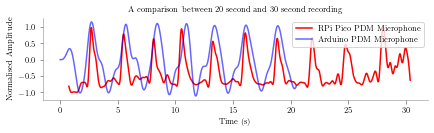

In [12]:
#now using hilbert transform
#https://www.atsjournals.org/doi/10.1164/ajrccm.162.3.9905104

lt.latexify(columns=2, fig_height=1.5)

filename="audacity-1.wav"
tidal, fs = librosa.load(filename, sr=4000)
tidal_t = [s/fs for s in range(0,len(tidal))]
#filtering using band passfilter
cutoff_low = 5
cutoff_low_lpf = 150
cutoff_high = 100
order = 5
#tidal_f = butter_bandpass_filter(tidal,cutoff_low,cutoff_high,fs,order)
tidal_f = butter_lowpass_filter(tidal,cutoff_low_lpf,fs,order)


x_filt_hilbert = signal.hilbert(tidal_f)
envelope_hat = np.abs(x_filt_hilbert)
#filter the Hilbert envelope
nyq_rate = fs /0.5
width = 1.0/nyq_rate # 5 Hz filter transition width.
ripple_db = 10.0 # stop band attenuation
fL_hz = 10
N, beta = signal.kaiserord(ripple_db, width)
taps = signal.firwin(N, fL_hz/nyq_rate, window=('kaiser', beta))
envelope_hat_filt = signal.filtfilt(taps, 1,envelope_hat)
peaks,_ = find_peaks(envelope_hat_filt, height=0.05)


fig, ax = plt.subplots(1,1)
#ax[0].plot(tidal_t, tidal,'k', alpha=0.5);
#ax[1].plot(tidal_t,tidal_f, 'b', alpha=0.6)


envelope_hat_filt = 2*((envelope_hat_filt-envelope_hat_filt.min())/(envelope_hat_filt.max()-envelope_hat_filt.min()))-1

ax.plot([i+0.75 for i in tidal_t],envelope_hat_filt,'r');
#ax.plot([tidal_t[peak] for peak in peaks], [envelope_hat_filt[i] for i in peaks], "x", color='black')
#ax[2].set_title("File name = {} and No. of breathing = {}".format(filename, (len(peaks)-2)//2))

filename="arduino-1.wav"
tidal, fs = librosa.load(filename, sr=4000)
tidal_t = [s/fs for s in range(0,len(tidal))]
#filtering using band passfilter
cutoff_low = 5
cutoff_low_lpf = 1
cutoff_high = 100
order = 5
#tidal_f = butter_bandpass_filter(tidal,cutoff_low,cutoff_high,fs,order)
tidal_f = butter_lowpass_filter(tidal,cutoff_low_lpf,fs,order)


x_filt_hilbert = signal.hilbert(tidal_f)
envelope_hat = np.abs(x_filt_hilbert)
#filter the Hilbert envelope
nyq_rate = fs /0.5
width = 1.0/nyq_rate # 5 Hz filter transition width.
ripple_db = 10.0 # stop band attenuation
fL_hz = 10
N, beta = signal.kaiserord(ripple_db, width)
taps = signal.firwin(N, fL_hz/nyq_rate, window=('kaiser', beta))
envelope_hat_filt = signal.filtfilt(taps, 1,envelope_hat)
peaks_ht,_ = find_peaks(envelope_hat_filt, height=0.05)
peaks_f,_ = find_peaks(tidal_f, height=0.5)


#ax[0].plot(tidal_t, tidal,'k', alpha=0.5);
ax.plot(tidal_t,tidal_f, 'b', alpha=0.6)
#ax.plot([tidal_t[peak] for peak in peaks_f], [tidal_f[i] for i in peaks_f], "x", color='black')

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.legend(['RPi Pico PDM Microphone','Arduino PDM Microphone'], fontsize=14)
ax.legend(['RPi Pico PDM Microphone','Arduino PDM Microphone'])
ax.set_title("A comparison between 20 second and 30 second recording")
ax.set_xlabel('Time (s)')
ax.set_ylabel('Normalised Amplitude')

lt.format_axes(ax)

plt.savefig('rpi-vs-arduino.pdf', bbox_inches='tight')


In [47]:
envelope_hat_filt.max()

2.400512922648579

In [48]:
np.max(envelope_hat_filt)

2.400512922648579